# Overturning Streamfunction

This draft notebook plots the depth-coordinate, $y$-averaged overturning streamfunction for each model at the end of the Ocean1 and Ocean2 runs.

In [1]:
#Load required packages
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import cftime
import cmocean as cm

from netCDF4 import Dataset
import os.path
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec

Models: 
```
COCO   MITgcm-BAS          MITgcm-JPL  MOM6_SIGMA_ZSTAR  NEMO-CNRS      POP2x
FVCOM  MITgcm_BAS_Coupled  MOM6        MPAS-Ocean        NEMO-UKESM1is  ROMS-UTAS
```

In [2]:
## folder where the isomip-plus github repo is located
baserepo = '/g/data/x77/cy8964/isomip-plus/'
## folder where you downloaded the zipped Google Drive data
basedrive = '/g/data/x77/cy8964/ISOMIP+Data-new/'

# load the data from the text files, which point to the right location of the file in the drive structure
Ocean0_COM = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean0-COM.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean1_COM = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean1-COM.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean2_COM = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean2-COM.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean0_TYP = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean0-TYP.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean1_TYP = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean1-TYP.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean2_TYP = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean2-TYP.txt', dtype = 'str', delimiter = ',',usecols = 0)

def get_labels(expt):
    '''
    Get labels of experiments
    Make some modifications to names
    '''
    labels = []
    for fileIndex in range(len(expt)):
        fileName = expt[fileIndex]
        baseName = os.path.basename(basedrive +fileName)
        modelName = ' '.join(baseName.split('_')[2:]).split('.')[0]
        if "COM" in fileName:
            #make edits to COM names
            if "MOM6" in fileName:
                if "SIGMA_ZSTAR" not in fileName:
                    modelName = modelName + '-LAYER'
            elif "ROMS" in fileName:
                modelName = "ROMS"
        elif "TYP" in fileName:
            # make edits to COM names
            if "MOM6" in fileName:
                modelName = modelName + '-LAYER'
            elif "CNRS" in fileName:
                if "TYPa" in fileName:
                    modelName = modelName + '-TYPa'
                elif "TYPb" in fileName:
                    modelName = modelName + '-TYPb'
            elif "tides" in fileName:
                modelName = "ROMS-tides"
            elif "ROMS" in fileName:
                modelName = "ROMS"
        labels.append(modelName.strip('V3').replace(" ", "-"))
    return labels


# Overturning Streamfunction

In [8]:
linewidths = np.ones(21)*0.7
linewidths[10]=1.5
linestyles = ['--','--','--','--','--','--','--','--','--','--',
              '-',
              '-','-','-','-','-','-','-','-','-','-',]
colors = ['k','k','k','k','k','k','k','k','k','k',
          'silver',
          'k','k','k','k','k','k','k','k','k','k',]

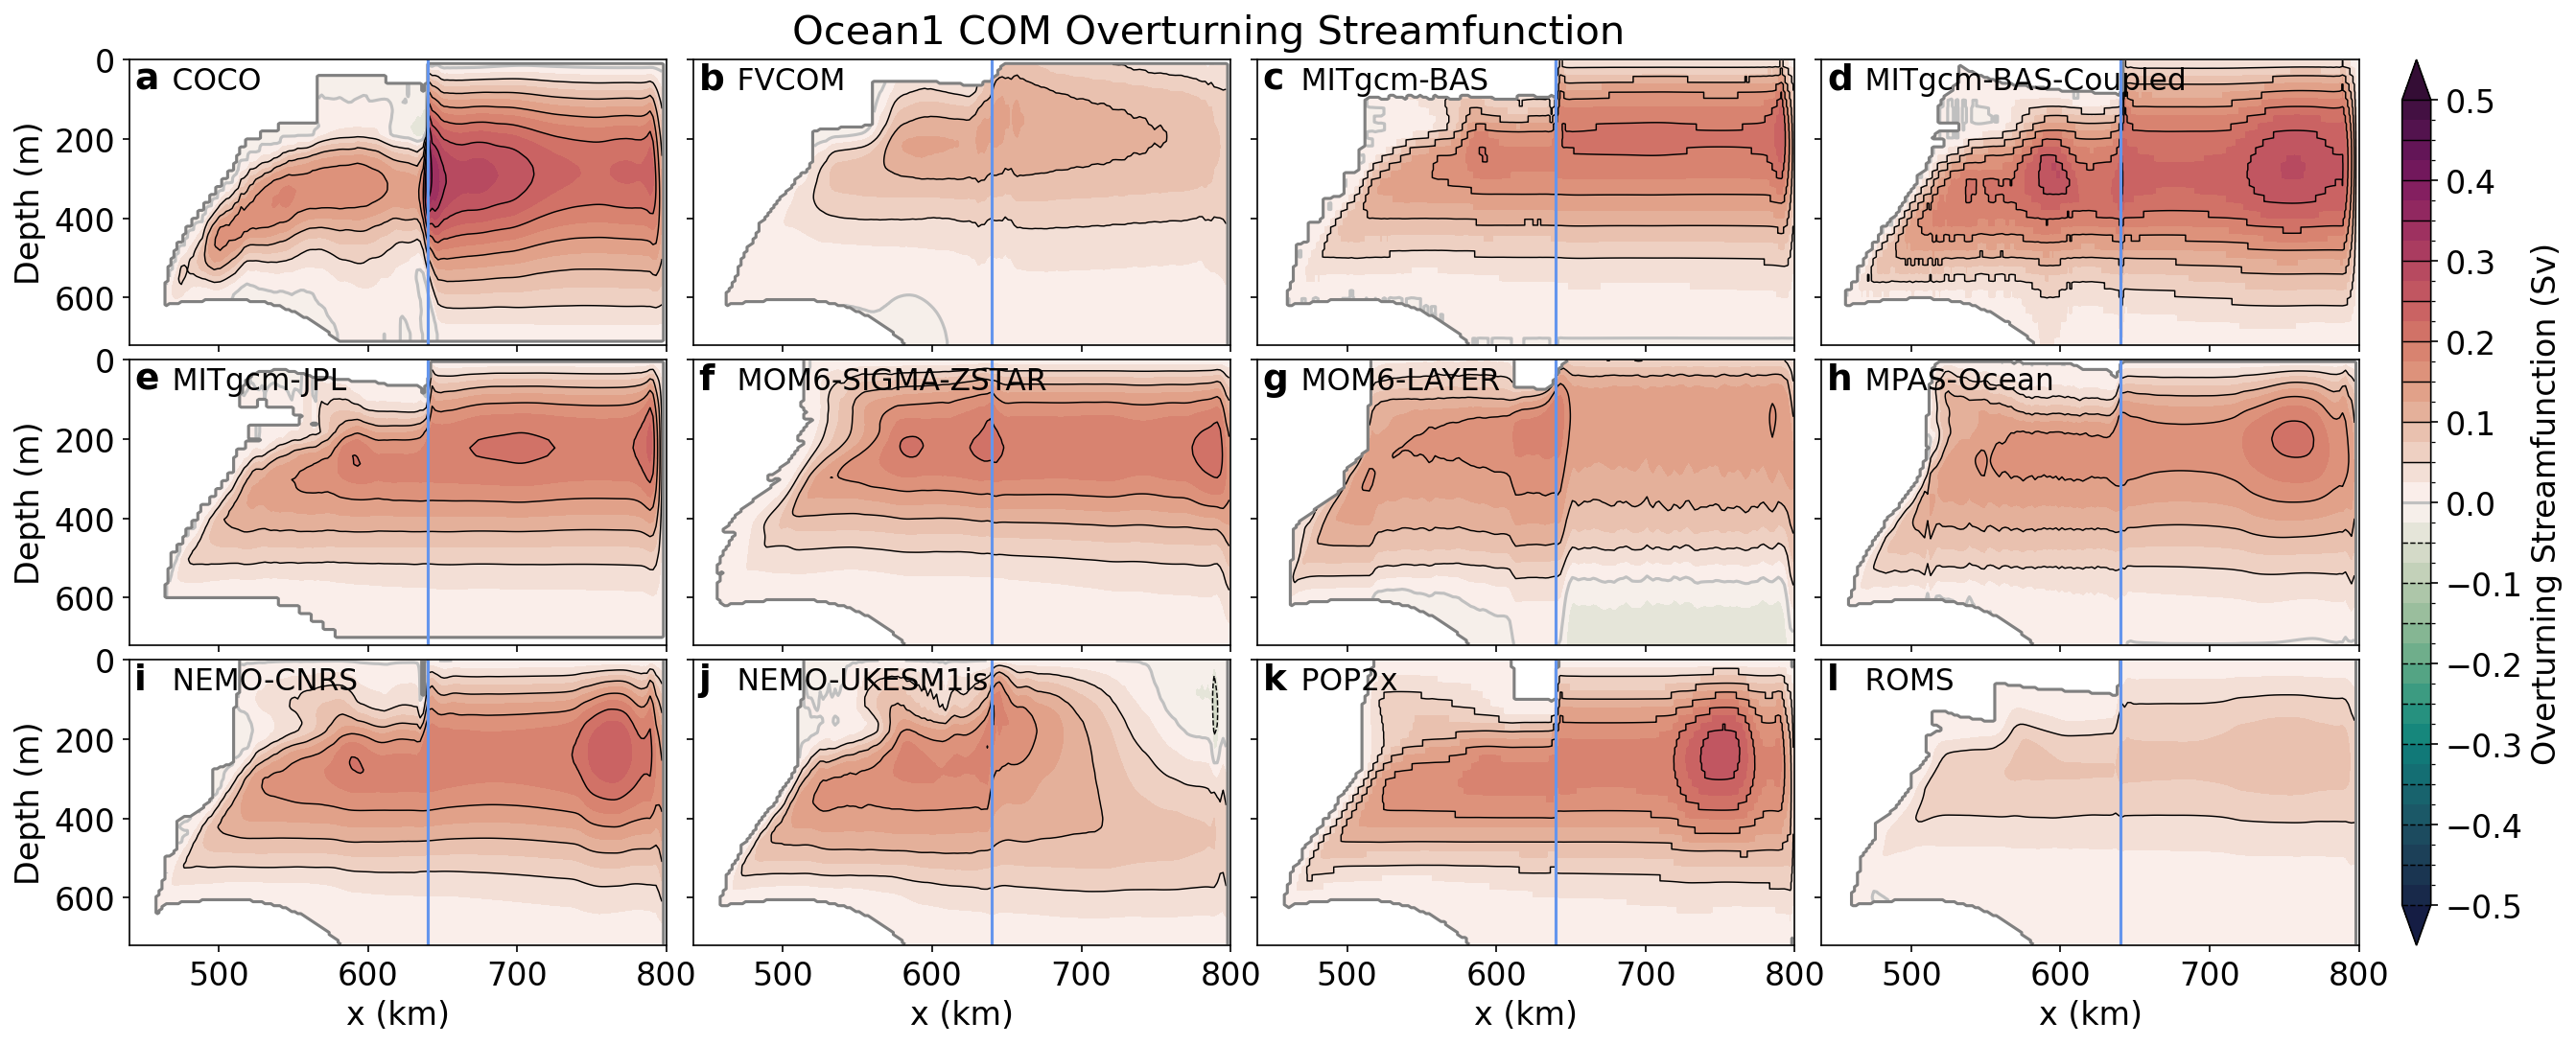

In [9]:
# Ocean1 again with new layout:

expt = Ocean1_COM
labels = get_labels(expt)

length = len(expt)
alphabet = ['a','b','c','d','e','f','g','h','i','j','k','l','m']

ncols = int(np.ceil(length/3))
gs = gridspec.GridSpec(nrows=3,ncols=ncols,wspace=0.05, hspace=0.05)
fig = plt.figure(figsize=(20,8),facecolor='w',dpi = 150)

time = 240
for i in np.arange(length):
    ax=fig.add_subplot(gs[i])
    data = xr.open_dataset(basedrive+expt[i], decode_times=False)
    mr = data.meltRate.isel(nTime = 0)
    mr = mr.where(mr<1e36).where(mr !=0)
    try:
        draft = data.iceDraft.isel(nTime=slice(time-12, time)).mean('nTime')
    except ValueError: #not time-dependent
        draft = data.iceDraft
    draft = np.abs(draft.where((draft<1e36)))
    try:
        bathy = data.bathymetry.isel(nTime = time)
    except ValueError:
        bathy = data.bathymetry#.isel(nTime = time)
    bathy = np.abs(bathy.where(bathy<1e36))

    if i==3:
        # get rid of very small layers in MITgcm-BAS-Coupled
        draft = draft.where(draft < bathy-1)
    
    draftminx = draft.min('ny')
    for j in np.arange(160,len(draftminx)):
        if not (draftminx[j]<1e36):
            draftminx[j]=0

    topomaxx = bathy.max('ny')    
    
    mr = data.overturningStreamfunction.isel(nTime = np.arange(time-13,time)).mean('nTime')
    # last year of time
    mr['nz'] = mr.nz*5+2.5 # add depth (2.5,7.5 etc)
    mr['nx'] = mr.nx*2+321
    mr = mr.where(mr.nz > draftminx).where(mr.nz < topomaxx)
    # mr<1e36 is to get rid of NaNs.
    c = (mr.where(mr < 1e36).where(mr !=0)/1e6).plot.contourf(cmap = cm.cm.curl, levels = np.linspace(-0.5,0.5,41),extend = 'both',add_colorbar = False)#, cbar_kwargs = {'label':'Overturning \n Streamfunction (Sv)'},extend = 'both')
    ls = (mr.where(mr < 1e36).where(mr !=0)/1e6).plot.contour( levels = np.linspace(-0.5,0.5,21), colors = colors, linestyles = linestyles, linewidths = linewidths)
    # if i ==3:
    #     plt.plot(mr.nx,topomaxx,color = 'k', alpha = 0.5)
    #     plt.plot(mr.nx,draftminx,color = 'k', alpha = 0.5)
    # else:
    (mr.where(mr < 1e36).where(mr !=0)*0+1).fillna(0).plot.contour(levels = [0.5],colors = 'gray')
    
    
    plt.text(0.01,0.99,alphabet[i], fontsize = 18, transform=ax.transAxes, fontweight='bold', va='top')
    plt.text(0.01,0.975,'    '+labels[i], fontsize = 15, transform=ax.transAxes, va='top')
    if (i==1) or (i==2) or (i==3) or (i==5) or (i==6) or (i==7) or (i==9) or (i==10) or (i==11):
        ax.set_yticklabels([])
    if (i<8):
        ax.set_xticklabels([])
    if (i==0) or (i==4) or (i==8):
        plt.ylabel('Depth (m)', fontsize = 16)
    else:
        plt.ylabel('')
    if i>=8:
        plt.xlabel('x (km)', fontsize = 16)
    else:
        plt.xlabel('')
    plt.vlines(640,720,0,color = 'cornflowerblue', linestyle = '-',linewidth =1.5)
    plt.ylim(720,0)
    plt.xlim(440,800)
    plt.tick_params(labelsize=16)

cax = plt.axes([0.915,0.11,0.01,0.77])
cbar = plt.colorbar(c, cax = cax,ticks=np.linspace(-0.5,0.5,11))
cbar.ax.set_ylabel('Overturning Streamfunction (Sv)', fontsize = 16)
cbar.add_lines(ls)
cbar.lines[-1].set_linestyles(ls.linestyles)
fig.subplots_adjust(wspace = 0.2, hspace = 0.35)
plt.tick_params(labelsize=16)

fig.suptitle('Ocean1 COM Overturning Streamfunction', y=0.92,fontsize = 20);

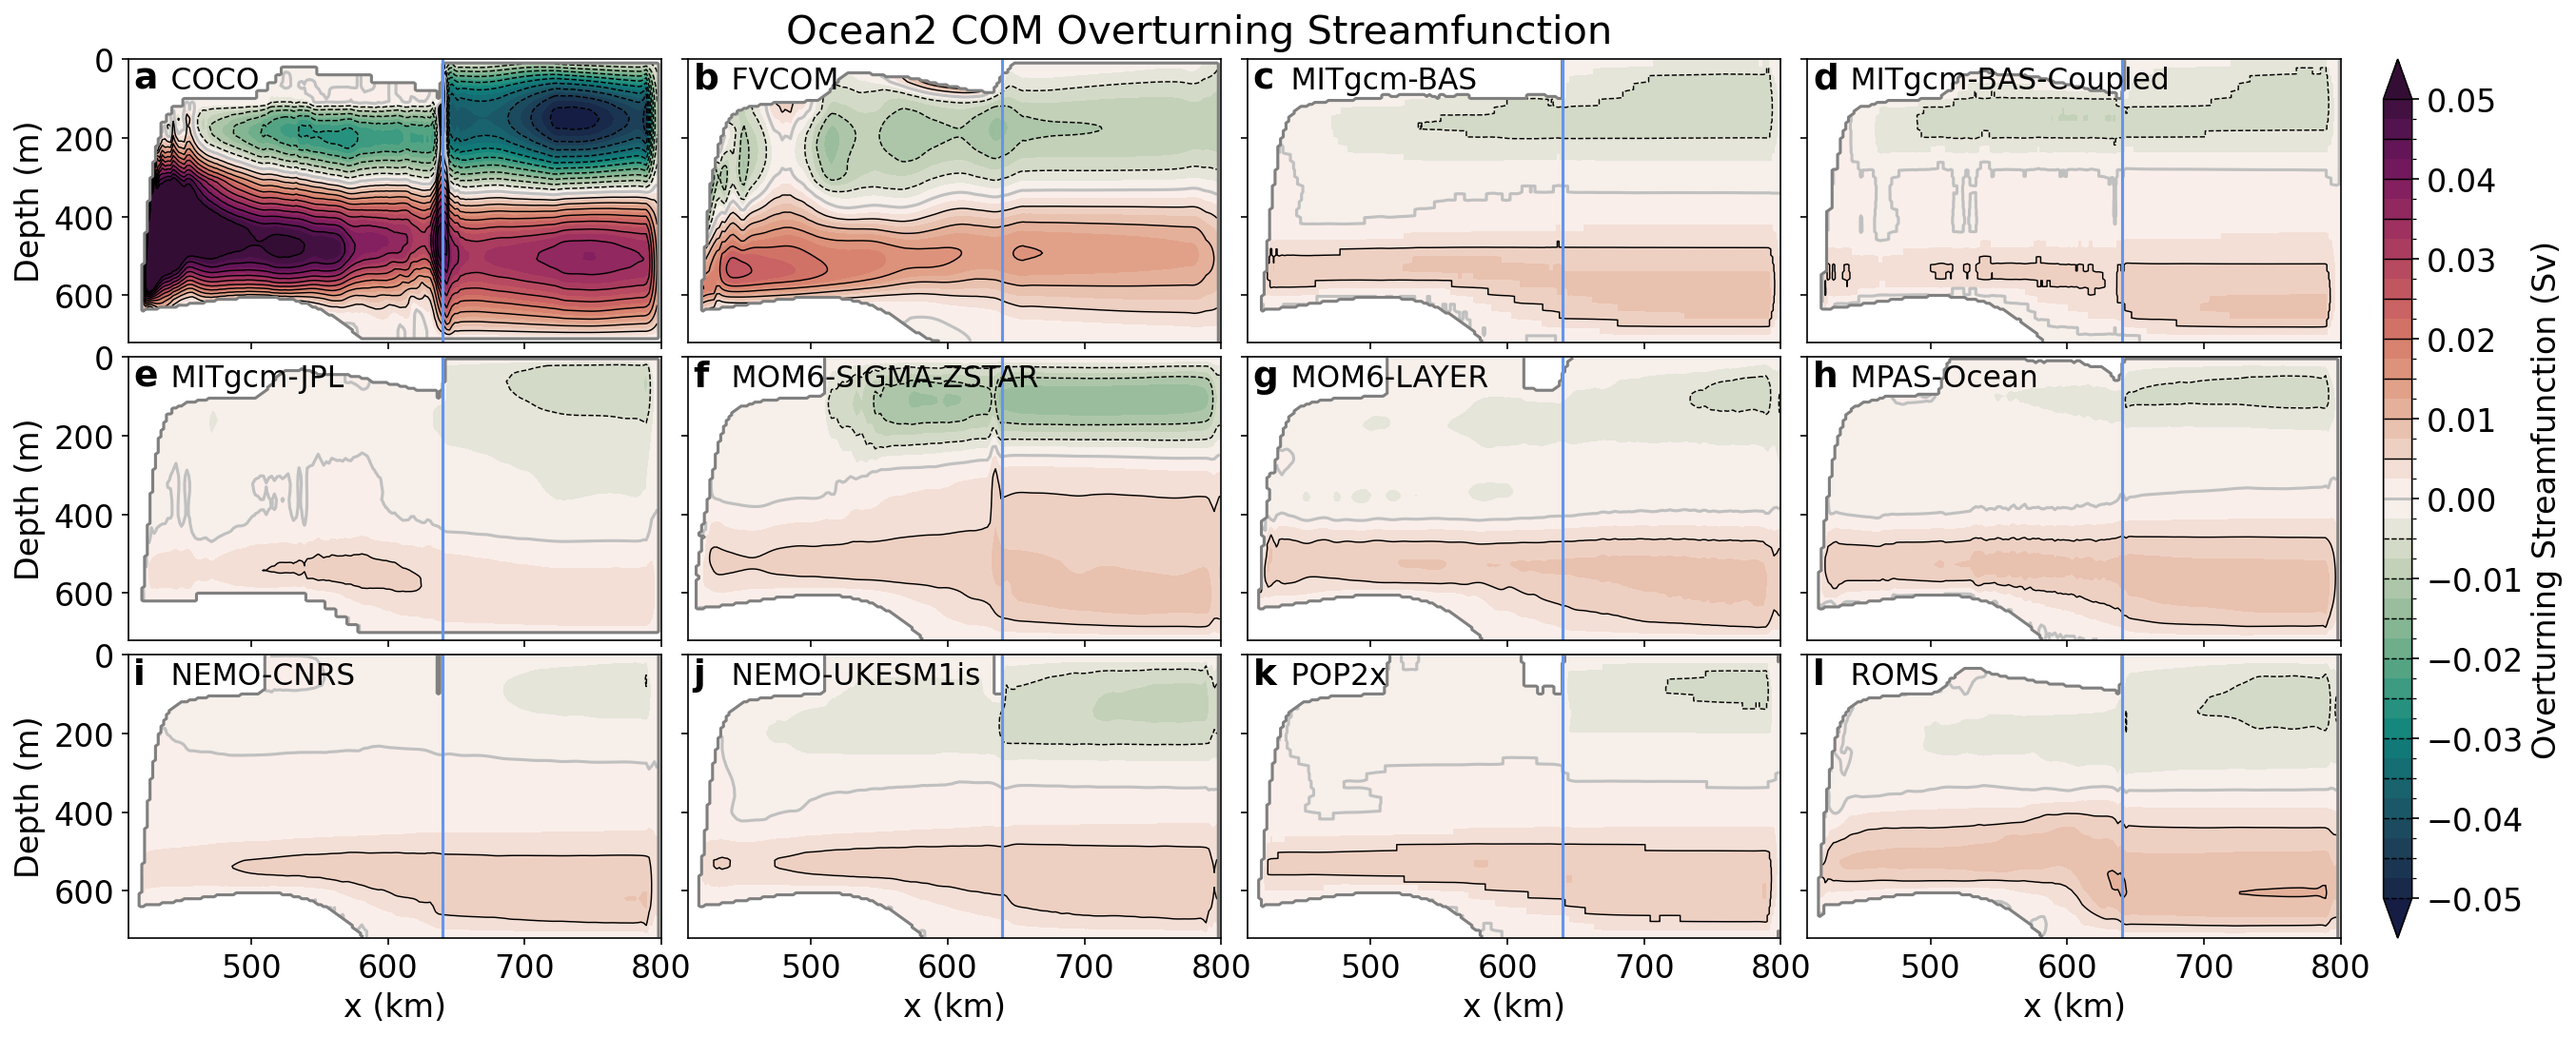

In [10]:
expt = Ocean2_COM
labels = get_labels(expt)

length = len(expt)
alphabet = ['a','b','c','d','e','f','g','h','i','j','k','l','m']

ncols = int(np.ceil(length/3))
gs = gridspec.GridSpec(nrows=3,ncols=ncols,wspace=0.05, hspace=0.05)
fig = plt.figure(figsize=(20,8),facecolor='w',dpi = 150)

time = 240
for i in np.arange(length):
    ax=fig.add_subplot(gs[i])
    data = xr.open_dataset(basedrive+expt[i], decode_times=False)
    mr = data.meltRate.isel(nTime = 0)
    mr = mr.where(mr<1e36).where(mr !=0)
    try:
        draft = data.iceDraft.isel(nTime=slice(time-12, time)).mean('nTime')
    except ValueError: #not time-dependent
        draft = data.iceDraft
    draft = np.abs(draft.where((draft<1e36)))
    try:
        bathy = data.bathymetry.isel(nTime = time)
    except ValueError:
        bathy = data.bathymetry#.isel(nTime = time)
    bathy = np.abs(bathy.where(bathy<1e36))
    if i==3:
        # get rid of very small layers in MITgcm-BAS-Coupled
        draft = draft.where(draft < bathy-1)
    if i==1:
        # load FVCOM TYP bathy data since empty in COM
        data2 = xr.open_dataset(basedrive+Ocean2_TYP[i], decode_times=False)
        try:
            bathy = data2.bathymetry.isel(nTime = time)
        except ValueError:
            bathy = data2.bathymetry#.isel(nTime = time)
        bathy = np.abs(bathy.where(bathy<1e36))
    
    draftminx = draft.min('ny')
    for j in np.arange(160,len(draftminx)):
        if not (draftminx[j]<1e36):
            draftminx[j]=0

    topomaxx = bathy.max('ny')    
    
    mr = data.overturningStreamfunction.isel(nTime = np.arange(time-13,time)).mean('nTime')
    # last year of time
    mr['nz'] = mr.nz*5+2.5 # add depth (2.5,7.5 etc)
    mr['nx'] = mr.nx*2+321
    mr = mr.where(mr.nz > draftminx).where(mr.nz < topomaxx)
    # mr<1e36 is to get rid of NaNs.
    c = (mr.where(mr < 1e36).where(mr !=0)/1e6).plot.contourf(cmap = cm.cm.curl, levels = np.linspace(-0.05,0.05,41),extend = 'both',add_colorbar = False)#, cbar_kwargs = {'label':'Overturning \n Streamfunction (Sv)'},extend = 'both')
    ls = (mr.where(mr < 1e36).where(mr !=0)/1e6).plot.contour( levels = np.linspace(-0.05,0.05,21), colors = colors, linestyles = linestyles, linewidths = linewidths)

    (mr.where(mr < 1e36).where(mr !=0)*0+1).fillna(0).plot.contour(levels = [0.5],colors = 'gray')
    
    #plt.plot(mr.nx,topomaxx,color = 'k', alpha = 0.5)
    #plt.plot(mr.nx,draftminx,color = 'k', alpha = 0.5)
    
    plt.text(0.01,0.99,alphabet[i], fontsize = 18, transform=ax.transAxes, fontweight='bold', va='top')
    plt.text(0.01,0.975,'    '+labels[i], fontsize = 15, transform=ax.transAxes, va='top')
    if (i==1) or (i==2) or (i==3) or (i==5) or (i==6) or (i==7) or (i==9) or (i==10) or (i==11):
        ax.set_yticklabels([])
    if (i<8):
        ax.set_xticklabels([])
    if (i==0) or (i==4) or (i==8):
        plt.ylabel('Depth (m)', fontsize = 16)
    else:
        plt.ylabel('')
    if i>=8:
        plt.xlabel('x (km)', fontsize = 16)
    else:
        plt.xlabel('')
    plt.vlines(640,720,0,color = 'cornflowerblue', linestyle = '-',linewidth =1.5)
    plt.ylim(720,0)
    plt.xlim(410,800)
    plt.tick_params(labelsize=16)

cax = plt.axes([0.915,0.11,0.01,0.77])
cbar = plt.colorbar(c, cax = cax,ticks=np.linspace(-0.05,0.05,11))
cbar.ax.set_ylabel('Overturning Streamfunction (Sv)', fontsize = 16)
cbar.add_lines(ls)
cbar.lines[-1].set_linestyles(ls.linestyles)
fig.subplots_adjust(wspace = 0.2, hspace = 0.35)
plt.tick_params(labelsize=16)

fig.suptitle('Ocean2 COM Overturning Streamfunction', y=0.92,fontsize = 20);

# TYP Plots

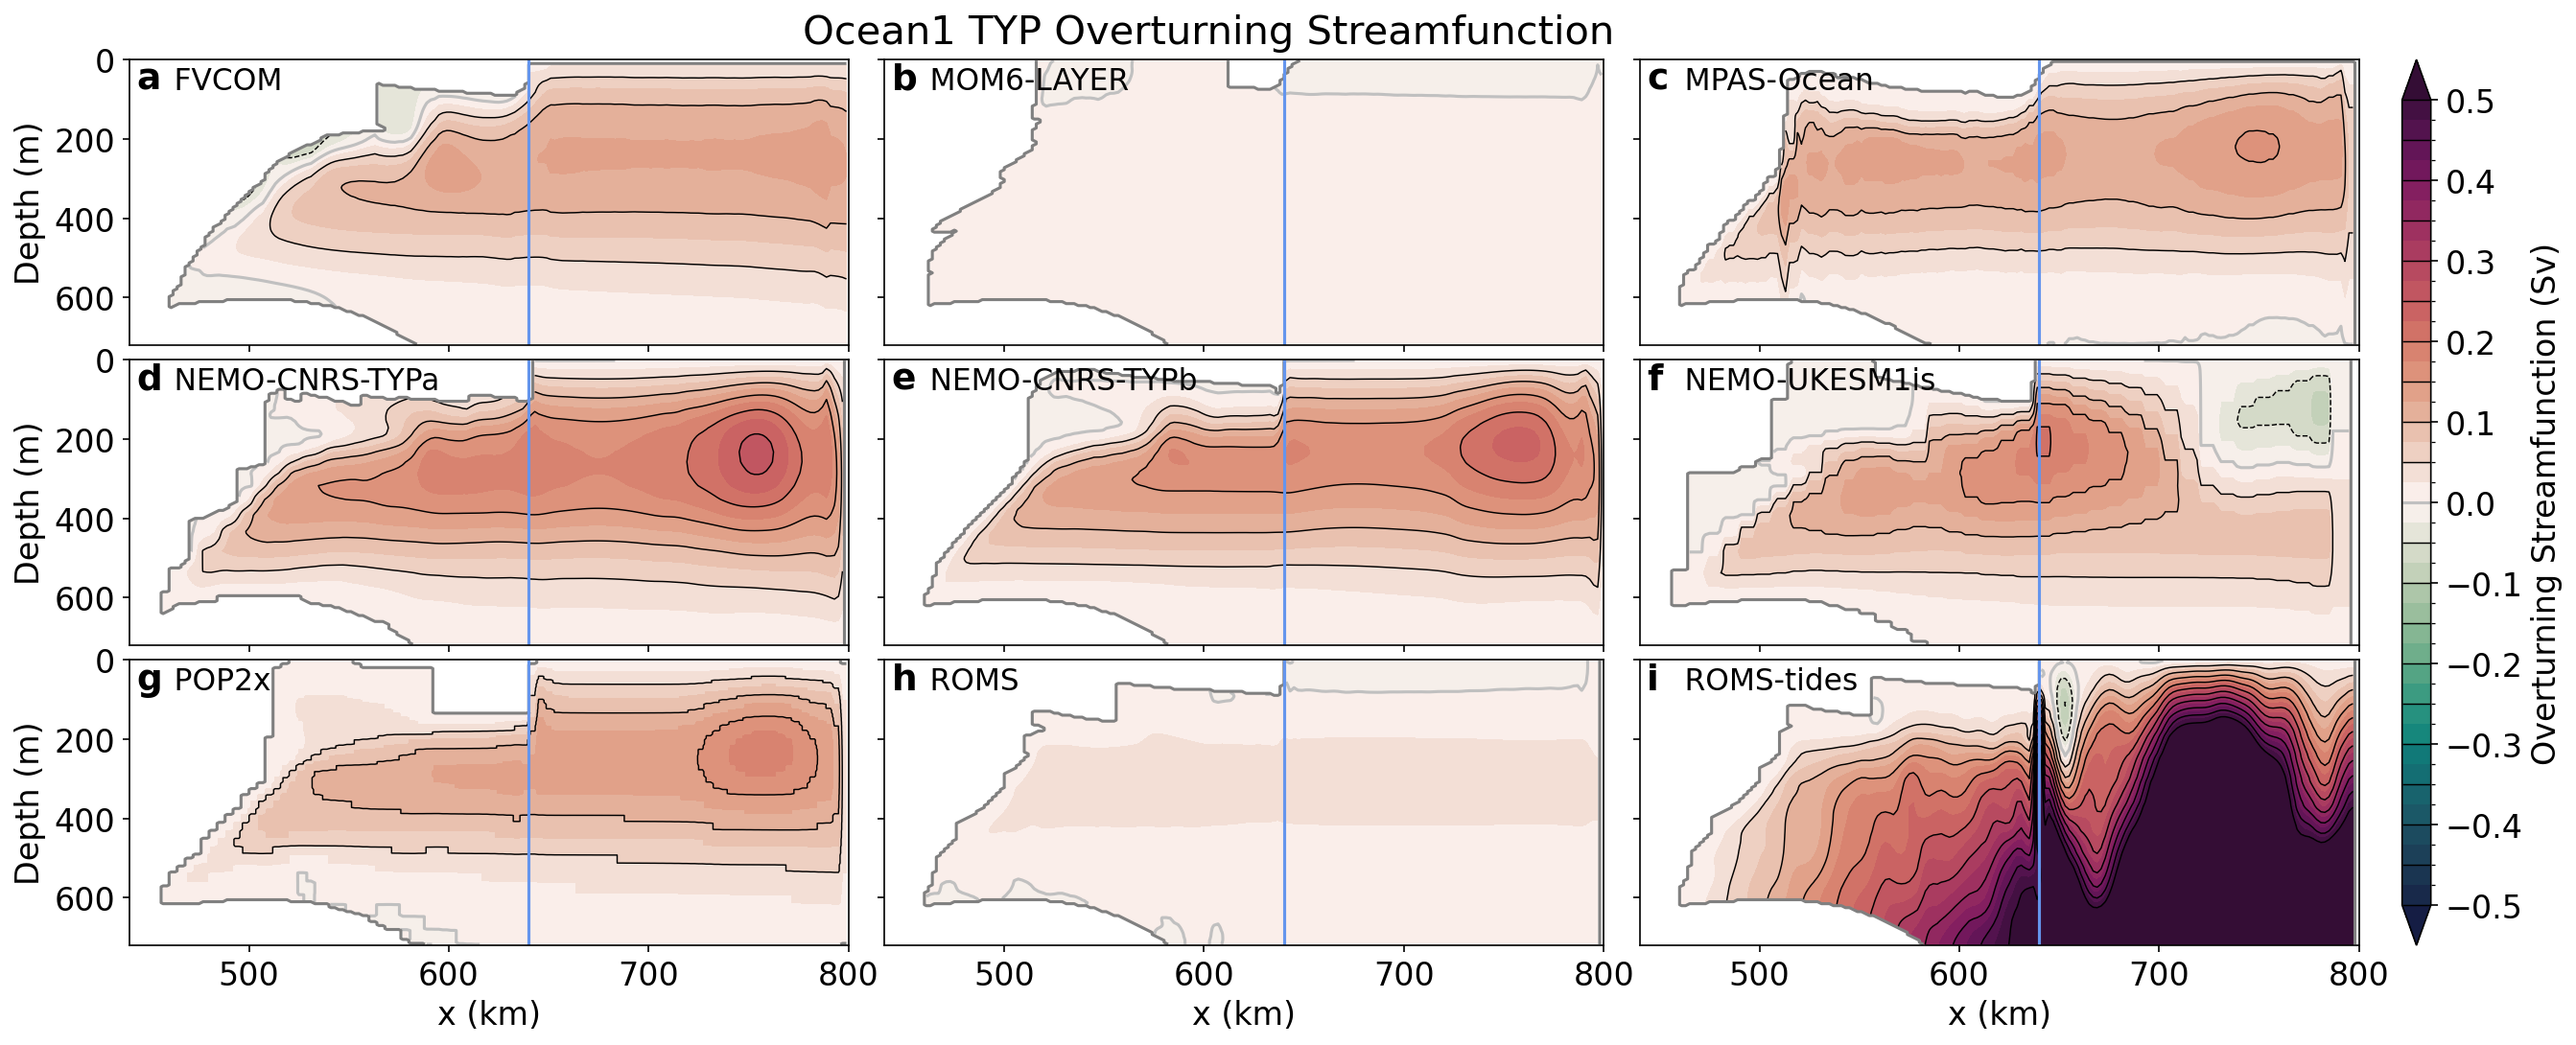

In [11]:
expt = Ocean1_TYP
labels = get_labels(expt)

length = len(expt)
alphabet = ['a','b','c','d','e','f','g','h','i','j','k','l','m']

ncols = int(np.ceil(length/3))
gs = gridspec.GridSpec(nrows=3,ncols=ncols,wspace=0.05, hspace=0.05)
fig = plt.figure(figsize=(20,8),facecolor='w',dpi = 150)

time = 240
for i in np.arange(length):
    ax=fig.add_subplot(gs[i])
    data = xr.open_dataset(basedrive+expt[i], decode_times=False)
    mr = data.meltRate.isel(nTime = 0)
    mr = mr.where(mr<1e36).where(mr !=0)
    try:
        draft = data.iceDraft.isel(nTime=slice(time-12, time)).mean('nTime')
    except ValueError: #not time-dependent
        draft = data.iceDraft
    draft = np.abs(draft.where((draft<1e36)))
    try:
        bathy = data.bathymetry.isel(nTime = time)
    except ValueError:
        bathy = data.bathymetry#.isel(nTime = time)
    bathy = np.abs(bathy.where(bathy<1e36))
    draftminx = draft.min('ny')
    for j in np.arange(160,len(draftminx)):
        if not (draftminx[j]<1e36):
            draftminx[j]=0

    topomaxx = bathy.max('ny')    
    
    mr = data.overturningStreamfunction.isel(nTime = np.arange(time-13,time)).mean('nTime')
    # last year of time
    mr['nz'] = mr.nz*5+2.5 # add depth (2.5,7.5 etc)
    mr['nx'] = mr.nx*2+321
    mr = mr.where(mr.nz > draftminx).where(mr.nz < topomaxx)
    # mr<1e36 is to get rid of NaNs.
    c = (mr.where(mr < 1e36).where(mr !=0)/1e6).plot.contourf(cmap = cm.cm.curl, levels = np.linspace(-0.5,0.5,41),extend = 'both',add_colorbar = False)#, cbar_kwargs = {'label':'Overturning \n Streamfunction (Sv)'},extend = 'both')
    ls = (mr.where(mr < 1e36).where(mr !=0)/1e6).plot.contour( levels = np.linspace(-0.5,0.5,21), colors = colors, linestyles = linestyles, linewidths = linewidths)

    (mr.where(mr < 1e36).where(mr !=0)*0+1).fillna(0).plot.contour(levels = [0.5],colors = 'gray')
    plt.text(0.01,0.99,alphabet[i], fontsize = 18, transform=ax.transAxes, fontweight='bold', va='top')
    plt.text(0.01,0.975,'    '+labels[i], fontsize = 15, transform=ax.transAxes, va='top')
    if (i==1) or (i==2) or (i==4) or (i==5) or (i==8) or (i==7):
        ax.set_yticklabels([])
    if (i<6):
        ax.set_xticklabels([])
    if (i==0) or (i==3) or (i==6):
        plt.ylabel('Depth (m)', fontsize = 16)
    else:
        plt.ylabel('')
    if i>=6:
        plt.xlabel('x (km)', fontsize = 16)
    else:
        plt.xlabel('')
    plt.vlines(640,720,0,color = 'cornflowerblue', linestyle = '-',linewidth =1.5)
    plt.ylim(720,0)
    plt.xlim(440,800)
    plt.tick_params(labelsize=16)

cax = plt.axes([0.915,0.11,0.01,0.77])
cbar = plt.colorbar(c, cax = cax,ticks=np.linspace(-0.5,0.5,11))
cbar.ax.set_ylabel('Overturning Streamfunction (Sv)', fontsize = 16)
cbar.add_lines(ls)
fig.subplots_adjust(wspace = 0.2, hspace = 0.35)
plt.tick_params(labelsize=16)

fig.suptitle('Ocean1 TYP Overturning Streamfunction', y=0.92,fontsize = 20);

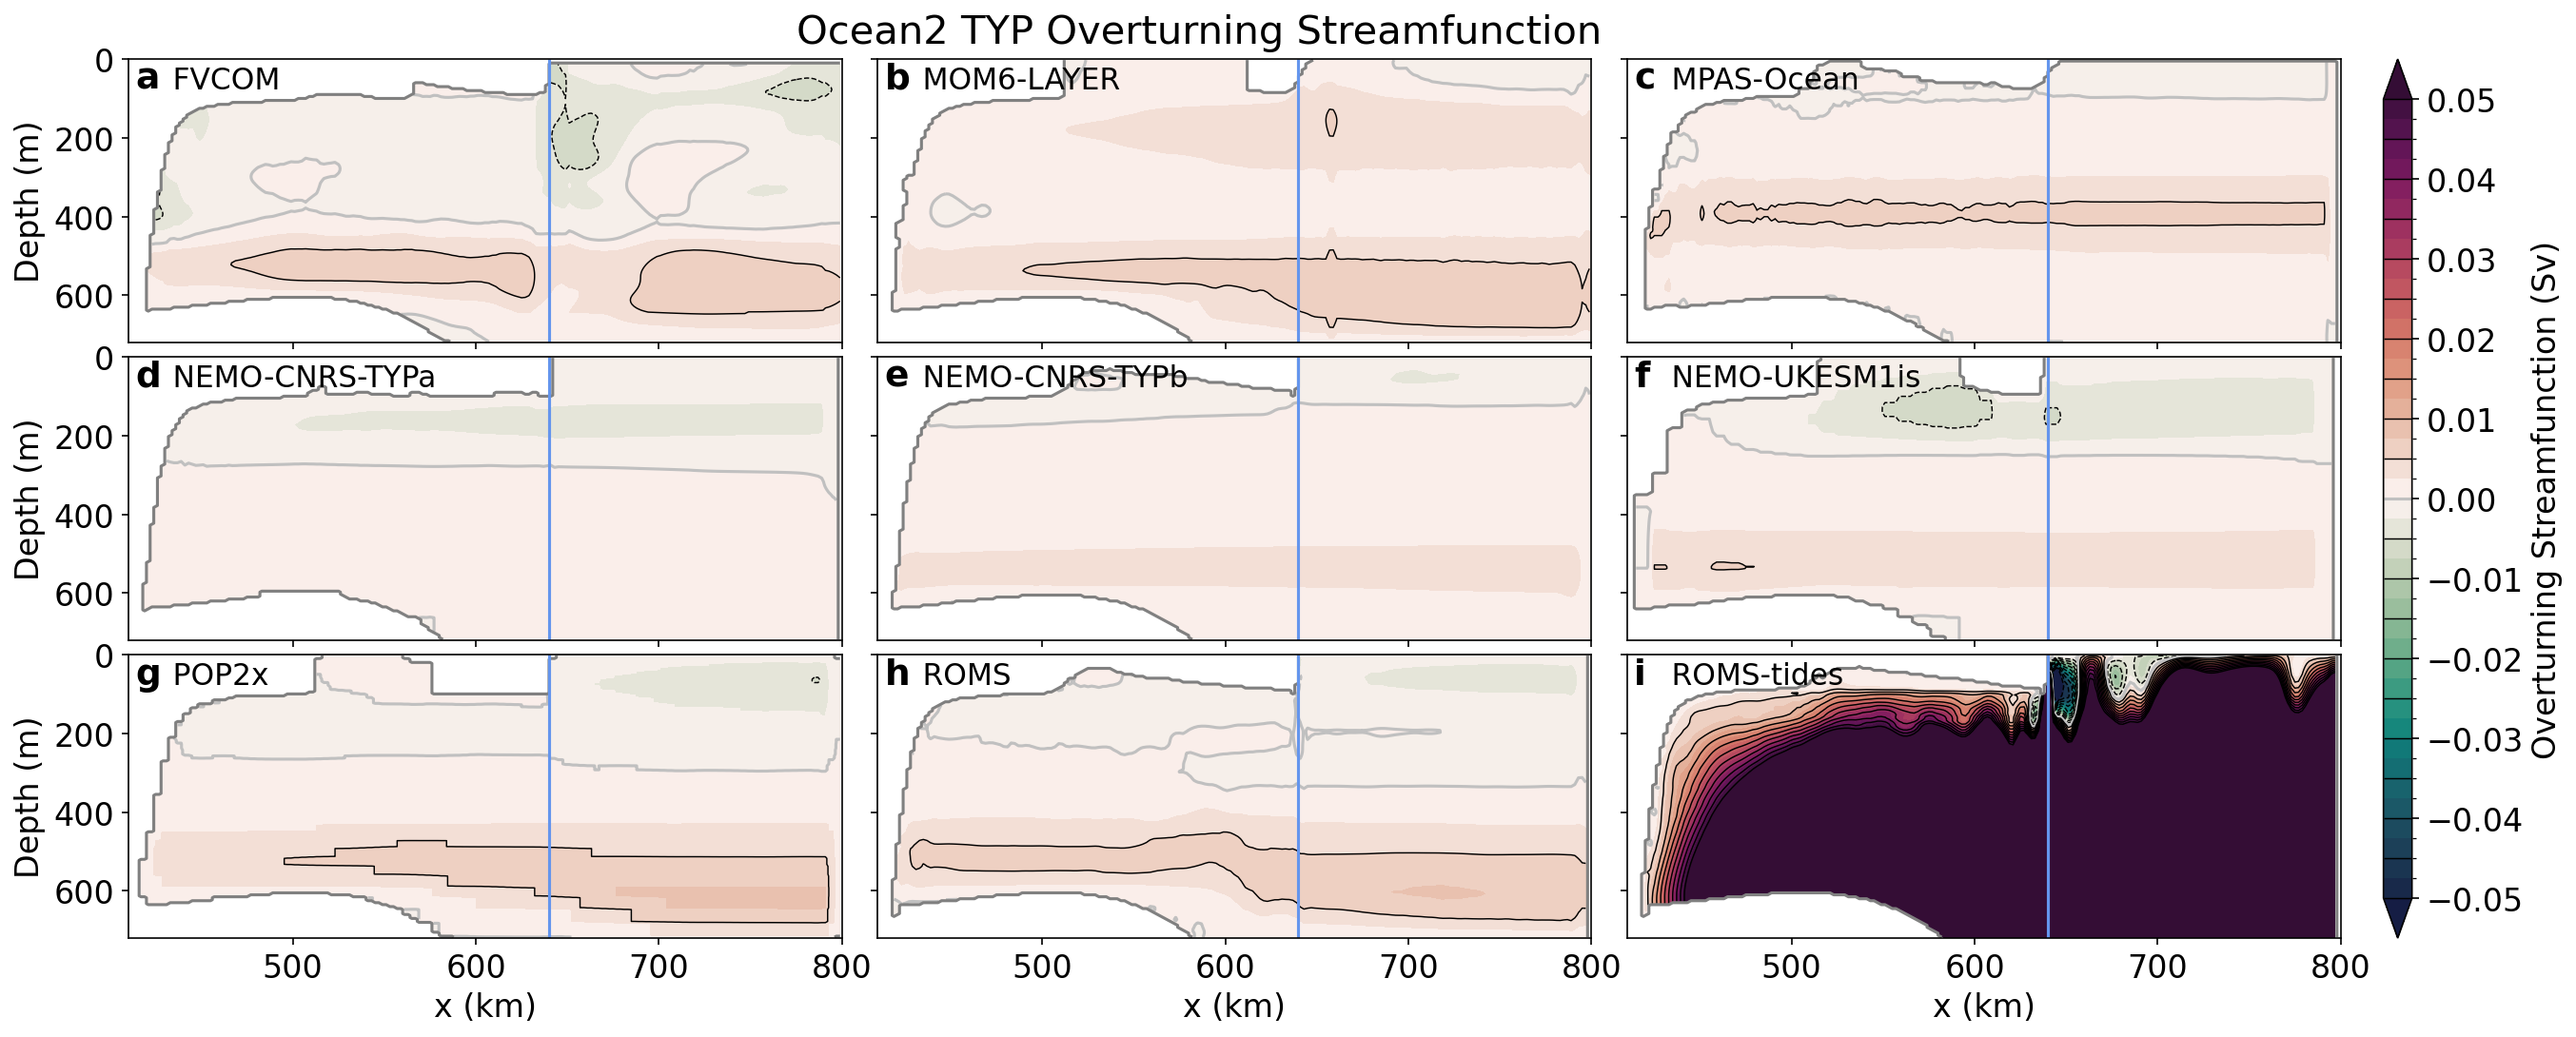

In [12]:
expt = Ocean2_TYP
labels = get_labels(expt)

length = len(expt)
alphabet = ['a','b','c','d','e','f','g','h','i','j','k','l','m']

ncols = int(np.ceil(length/3))
gs = gridspec.GridSpec(nrows=3,ncols=ncols,wspace=0.05, hspace=0.05)
fig = plt.figure(figsize=(20,8),facecolor='w',dpi = 150)

time = 240
for i in np.arange(length):
    ax=fig.add_subplot(gs[i])
    data = xr.open_dataset(basedrive+expt[i], decode_times=False)
    mr = data.meltRate.isel(nTime = 0)
    mr = mr.where(mr<1e36).where(mr !=0)
    try:
        draft = data.iceDraft.isel(nTime=slice(time-12, time)).mean('nTime')
    except ValueError: #not time-dependent
        draft = data.iceDraft
    draft = np.abs(draft.where((draft<1e36)))
    try:
        bathy = data.bathymetry.isel(nTime = time)
    except ValueError:
        bathy = data.bathymetry#.isel(nTime = time)
    bathy = np.abs(bathy.where(bathy<1e36))
    draftminx = draft.min('ny')
    for j in np.arange(160,len(draftminx)):
        if not (draftminx[j]<1e36):
            draftminx[j]=0

    topomaxx = bathy.max('ny')    
    
    mr = data.overturningStreamfunction.isel(nTime = np.arange(time-13,time)).mean('nTime')
    # last year of time
    mr['nz'] = mr.nz*5+2.5 # add depth (2.5,7.5 etc)
    mr['nx'] = mr.nx*2+321
    mr = mr.where(mr.nz > draftminx).where(mr.nz < topomaxx)
    # mr<1e36 is to get rid of NaNs.
    c = (mr.where(mr < 1e36).where(mr !=0)/1e6).plot.contourf(cmap = cm.cm.curl, levels = np.linspace(-0.05,0.05,41),extend = 'both',add_colorbar = False)#, cbar_kwargs = {'label':'Overturning \n Streamfunction (Sv)'},extend = 'both')
    ls = (mr.where(mr < 1e36).where(mr !=0)/1e6).plot.contour( levels = np.linspace(-0.05,0.05,21), colors = colors, linestyles = linestyles, linewidths = linewidths)

    (mr.where(mr < 1e36).where(mr !=0)*0+1).fillna(0).plot.contour(levels = [0.5],colors = 'gray')
    plt.text(0.01,0.99,alphabet[i], fontsize = 18, transform=ax.transAxes, fontweight='bold', va='top')
    plt.text(0.01,0.975,'    '+labels[i], fontsize = 15, transform=ax.transAxes, va='top')
    if (i==1) or (i==2) or (i==4) or (i==5) or (i==8) or (i==7):
        ax.set_yticklabels([])
    if (i<6):
        ax.set_xticklabels([])
    if (i==0) or (i==3) or (i==6):
        plt.ylabel('Depth (m)', fontsize = 16)
    else:
        plt.ylabel('')
    if i>=6:
        plt.xlabel('x (km)', fontsize = 16)
    else:
        plt.xlabel('')
    plt.vlines(640,720,0,color = 'cornflowerblue', linestyle = '-',linewidth =1.5)
    plt.ylim(720,0)
    plt.xlim(410,800)
    plt.tick_params(labelsize=16)

cax = plt.axes([0.915,0.11,0.01,0.77])
cbar = plt.colorbar(c, cax = cax,ticks=np.linspace(-0.05,0.05,11))
cbar.ax.set_ylabel('Overturning Streamfunction (Sv)', fontsize = 16)
cbar.add_lines(ls)
fig.subplots_adjust(wspace = 0.2, hspace = 0.35)
plt.tick_params(labelsize=16)

fig.suptitle('Ocean2 TYP Overturning Streamfunction', y=0.92,fontsize = 20);